C:\Users\Admin\AppData\Local\Temp\ipykernel_9644\17015140.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Order Date'] = pd.to_datetime(product_data['Order Date'], format='%d/%m/%Y')
d:\project\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\project\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\project\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\project\venv\Lib\site-packages\sklearn\base.

MSE: 69.94531736124783, MAE: 4892.347420765677, R2: -0.3720923020168154


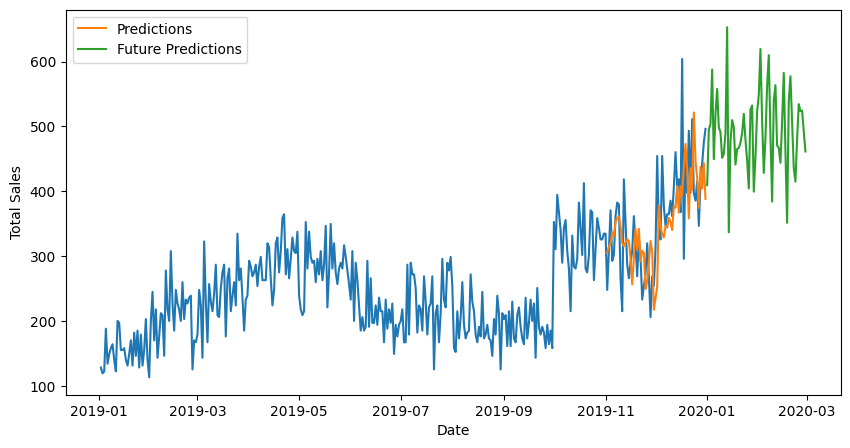

         date  Future Predictions
0  2020-01-01          409.428884
1  2020-01-02          495.163033
2  2020-01-03          503.721961
3  2020-01-04          587.740117
4  2020-01-05          449.537527
5  2020-01-06          519.241965
6  2020-01-07          557.895112
7  2020-01-08          498.549497
8  2020-01-09          491.295100
9  2020-01-10          451.675912
10 2020-01-11          457.625982
11 2020-01-12          490.427052
12 2020-01-13          652.908303
13 2020-01-14          336.882634
14 2020-01-15          477.487658
15 2020-01-16          509.736761
16 2020-01-17          499.235445
17 2020-01-18          441.216365
18 2020-01-19          465.205023
19 2020-01-20          467.056384
20 2020-01-21          474.954257
21 2020-01-22          489.844142
22 2020-01-23          519.375924
23 2020-01-24          479.539242
24 2020-01-25          447.738875
25 2020-01-26          404.525540
26 2020-01-27          526.144394
27 2020-01-28          532.170364
28 2020-01-29 

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Đọc dữ liệu
data = pd.read_csv('SalesAll2019.csv')

# Lọc dữ liệu cho sản phẩm "AAA Batteries (4-pack)"
product_data = data[data['Product'] == 'AAA Batteries (4-pack)']

# Chuyển đổi Order Date thành ngày tháng
product_data['Order Date'] = pd.to_datetime(product_data['Order Date'], format='%d/%m/%Y')

# Tạo dải ngày từ ngày bắt đầu đến ngày kết thúc
start_date = product_data['Order Date'].min()
end_date = product_data['Order Date'].max()
all_dates = pd.date_range(start=start_date, end=end_date)

# Tính doanh thu hàng ngày
daily_sales = product_data.groupby('Order Date')['Total Price'].sum().reindex(all_dates, fill_value=0).reset_index()
daily_sales.columns = ['date', 'Total Price']
daily_sales.drop(daily_sales.tail(1).index, inplace=True)

# Tính tiền bán theo tháng
daily_sales['date'] = daily_sales['date']
m_sales = daily_sales

# Thêm cột sale_diff
m_sales['sale_diff'] = m_sales['Total Price'].diff()
m_sales = m_sales.dropna()

supervised_data = m_sales.drop(['date', 'Total Price'], axis=1)
for i in range(1, 61):
    col_name = 'D_' + str(i)
    supervised_data[col_name] = supervised_data['sale_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = supervised_data[:-60]
test_data = supervised_data[-60:]

# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

# Huấn luyện mô hình Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)  # Huấn luyện mô hình trên tập huấn luyện

# Dự đoán trên tập kiểm tra
lr_pre = lr_model.predict(x_test).reshape(-1, 1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

# Tạo DataFrame để lưu trữ dự đoán
sales_date = m_sales['date'][-60:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_date)
act_sales = m_sales['Total Price'][-61:].to_list()

result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

# Tính các chỉ số đánh giá
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], m_sales['Total Price'][-60:]))
lr_mae = mean_squared_error(predict_df['Linear Prediction'], m_sales['Total Price'][-60:])
lr_r2 = r2_score(predict_df['Linear Prediction'], m_sales['Total Price'][-60:])
print(f'MSE: {lr_mse}, MAE: {lr_mae}, R2: {lr_r2}')

# Dự đoán 60 ngày tiếp theo
future_predictions = []
last_known_data = supervised_data.tail(1).values

for _ in range(60):
    scaled_data = scaler.transform(last_known_data)
    x_future = scaled_data[:, 1:]
    y_future_pred = lr_model.predict(x_future)
    y_future_pred_scaled = np.concatenate([y_future_pred.reshape(-1, 1), x_future], axis=1)
    y_future_pred_original = scaler.inverse_transform(y_future_pred_scaled)[0][0]
    future_predictions.append(y_future_pred_original + act_sales[-1])
    
    # Cập nhật last_known_data để sử dụng dự đoán này cho lần tiếp theo
    last_known_data = np.roll(last_known_data, -1)
    last_known_data[0, 0] = y_future_pred_original

# Thêm dự đoán vào DataFrame
future_dates = pd.date_range(start=predict_df['date'].iloc[-1], periods=61, inclusive='right')
future_df = pd.DataFrame({'date': future_dates, 'Future Predictions': future_predictions})

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(m_sales['date'],m_sales['Total Price'])
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Predictions')
plt.plot(future_df['date'], future_df['Future Predictions'], label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

print(future_df)


In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Đọc dữ liệu
data = pd.read_csv('SalesAll2019.csv')

# Lọc dữ liệu cho sản phẩm "AAA Batteries (4-pack)"
product_data = data[data['Product'] == 'AAA Batteries (4-pack)']

# Chuyển đổi Order Date thành ngày tháng
product_data['Order Date'] = pd.to_datetime(product_data['Order Date'], format='%d/%m/%Y')

# Tạo dải ngày từ ngày bắt đầu đến ngày kết thúc
start_date = product_data['Order Date'].min()
end_date = product_data['Order Date'].max()
all_dates = pd.date_range(start=start_date, end=end_date)

# Tính doanh thu hàng ngày
daily_sales = product_data.groupby('Order Date')['Total Price'].sum().reindex(all_dates, fill_value=0).reset_index()
daily_sales.columns = ['Date', 'Total Price']
daily_sales.drop(daily_sales.tail(1).index, inplace=True)
# Chuyển đổi ngày thành số ngày kể từ ngày bắt đầu để hồi quy tuyến tính
daily_sales['Day Number'] = (daily_sales['Date'] - start_date).dt.days

# Huấn luyện mô hình hồi quy tuyến tính
X = daily_sales[['Day Number']]
y = daily_sales['Total Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

# In kết quả
print(f'R²: {r2:.4f}')

# Dự đoán doanh thu cho các ngày trong tương lai
future_dates = pd.date_range(start=end_date + pd.Timedelta(days=1), periods=30)
future_days = (future_dates - start_date).days
future_df = pd.DataFrame({'Day Number': future_days})
predictions = model.predict(future_df)
future_df['Predicted Revenue'] = predictions

print(future_df)





R²: 0.3590
    Day Number  Predicted Revenue
0          366         323.011164
1          367         323.392278
2          368         323.773392
3          369         324.154506
4          370         324.535619
5          371         324.916733
6          372         325.297847
7          373         325.678960
8          374         326.060074
9          375         326.441188
10         376         326.822302
11         377         327.203415
12         378         327.584529
13         379         327.965643
14         380         328.346756
15         381         328.727870
16         382         329.108984
17         383         329.490098
18         384         329.871211
19         385         330.252325
20         386         330.633439
21         387         331.014553
22         388         331.395666
23         389         331.776780
24         390         332.157894
25         391         332.539007
26         392         332.920121
27         393         333.301235
28 

C:\Users\Admin\AppData\Local\Temp\ipykernel_9644\360071248.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Order Date'] = pd.to_datetime(product_data['Order Date'], format='%d/%m/%Y')
